# Условие
Постройте классификатор спама

• Загрузите примеры спама и нормальных сообщений из наборов
данных https://spamassassin.apache.org/old/publiccorpus/

• Распакуйте наборы данных и ознакомьтесь с форматом данных.

• Разделите наборы данных на обучающий набор и испытательный
набор.

• Создайте конвейер подготовки данных для преобразования каждого
почтового сообщения в вектор признаков. Ваш конвейер подготовки
данных должен трансформировать почтовое сообщение в вектор,
который указывает на наличие или отсутствие каждого возможного
слова. Например, если все почтовые сообщения содержат только
четыре слова, “Hello”, “how”, “are”, “you”, тогда сообщение “Hello
you Hello Hello you” было бы преобразовано в вектор [1, 0, 0, 1], или
[3, 0, 0, 2], если вы предпочитаете подсчитывать количество
вхождений каждого слова.
Можете добавить гиперпараметры к своему конвейеру подготовки
данных, чтобы управлять тем,
- производить ли разбор заголовков почтовых сообщений,
- приводить ли символы каждого сообщения книжнему регистру,
- удалять ли символы пунктуации,
- замещать ли все URL строкой “URL”,
- заменять ли все числа строкой “NUMBER”

или даже
- выполнять ли морфологический поиск (stemming), т.е. исключение окончаний слов (для этого доступно несколько библиотек Python).

• Проведите тестирование нескольких классификаторов. Уровень
точности и полноты должен быть не менее 0.94.

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import re
import nltk
import string
from nltk.stem import SnowballStemmer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Загрузка данных

In [ ]:
import os

DATASETS_DIR = 'datasets'
MODELS_DIR = 'models'
TAR_DIR = os.path.join(DATASETS_DIR, 'tar')

SPAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2'
EASY_HAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2'
HARD_HAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2'

In [ ]:
from urllib.request import urlretrieve
import tarfile
import shutil

def download_dataset(url):
    """download and unzip data from a url into the specified path"""

    # create directory if it doesn't exist
    if not os.path.isdir(TAR_DIR):
        os.makedirs(TAR_DIR)

    filename = url.rsplit('/', 1)[-1]
    tarpath = os.path.join(TAR_DIR, filename)

    # download the tar file if it doesn't exist
    try:
        tarfile.open(tarpath)
    except:
        urlretrieve(url, tarpath)

    with tarfile.open(tarpath) as tar:
        dirname = os.path.join(DATASETS_DIR, tar.getnames()[0])
        if os.path.isdir(dirname):
            shutil.rmtree(dirname)
        tar.extractall(path=DATASETS_DIR)

        cmds_path = os.path.join(dirname, 'cmds')
        if os.path.isfile(cmds_path):
            os.remove(cmds_path)

    return dirname

In [ ]:
spam_dir = download_dataset(SPAM_URL)

In [ ]:
easy_ham_dir = download_dataset(EASY_HAM_URL)

In [ ]:
hard_ham_dir = download_dataset(HARD_HAM_URL)

In [ ]:
import numpy as np
import glob

def load_dataset(dirpath):
    """load emails from the specified directory"""

    files = []
    filepaths = glob.glob(dirpath + '/*')
    for path in filepaths:
        with open(path, 'rb') as f:
            byte_content = f.read()
            str_content = byte_content.decode('utf-8', errors='ignore')
            files.append(str_content)
    return files

# load the datasets
spam = load_dataset(spam_dir)
easy_ham = load_dataset(easy_ham_dir)
hard_ham = load_dataset(hard_ham_dir)

In [ ]:
print(easy_ham[10])

From fork-admin@xent.com  Fri Jul 19 20:20:11 2002
Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id A1902440C8
	for <jm@localhost>; Fri, 19 Jul 2002 15:20:09 -0400 (EDT)
Received: from dogma.slashnull.org [212.17.35.15]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Fri, 19 Jul 2002 20:20:09 +0100 (IST)
Received: from xent.com ([64.161.22.236]) by dogma.slashnull.org
    (8.11.6/8.11.6) with ESMTP id g6JJKFJ27780 for <jm@jmason.org>;
    Fri, 19 Jul 2002 20:20:16 +0100
Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)
    with ESMTP id A3AC32940AB; Fri, 19 Jul 2002 12:09:48 -0700 (PDT)
Delivered-To: fork@spamassassin.taint.org
Received: from venus.phpwebhosting.com (venus.phpwebhosting.com
    [64.29.16.27]) by xent.com (Postfix) with SMTP id 3C6A7294098 for
    <fork@xent.com>; Fri, 19 Jul 2002 12:09:

# Формирование датасета и переменных

In [ ]:
messages_list = easy_ham + hard_ham + spam
messages_labels = np.concatenate((np.zeros(len(easy_ham) + len(hard_ham)), np.ones(len(spam))))

In [ ]:
messages_data = pd.DataFrame(
                    list(zip(messages_list, messages_labels)),
                    columns =['message', 'label'])
messages_data.head()

,message,label
0,From iiu-admin@taint.org Wed Jul 24 14:04:29 ...,0.0
1,From fork-admin@xent.com Tue Aug 20 22:25:35 ...,0.0
2,From razor-users-admin@lists.sourceforge.net ...,0.0
3,From fork-admin@xent.com Mon Aug 12 11:07:37 ...,0.0
4,From ilug-admin@linux.ie Wed Aug 14 11:00:58 ...,0.0


In [ ]:
messages_data.isnull().sum()

message    0
label      0
dtype: int64

In [ ]:
messages_data.duplicated().sum()

0

In [ ]:
X = messages_data.message
y = messages_data.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Препроцессинг данных

Выдернем из каждого сообщения только содержательную часть (текст самого сообщения), по которой мы и будем проводить классификацию

Создадим датафрейм с сообщениями и их метками

In [ ]:
def transformator(messages_list,
                  remove_headers=True,
                  to_lowercase=True,
                  remove_punctuation=True,
                  transform_urls=True,
                  transform_numbers=True,
                  remove_word_endings=True):

    if remove_headers is True:
        messages_list = [msg[msg.index('\n\n'):] for msg in messages_list]

    if to_lowercase is True:
        messages_list = [msg.lower() for msg in messages_list]

    if transform_urls is True:
        pattern = r'(https?://\S+)'
        for i in range(len(messages_list)):
            if isinstance(messages_list[i], str):
                messages_list[i] = re.sub(pattern, 'URL', messages_list[i])

    if transform_numbers is True:
        pattern = r'\d+'
        for i in range(len(messages_list)):
            if isinstance(messages_list[i], str):
                words = messages_list[i].split()
                for j in range(len(words)):
                    if words[j].isdigit():
                        words[j] = 'NUM'
                    else:
                        words[j] = re.sub(pattern, 'NUM', words[j])
                messages_list[i] = ' '.join(words)

    if remove_word_endings is True:
        stemmer = SnowballStemmer('english')
        no_endings_list = []

        for msg in messages_list:
            words = nltk.word_tokenize(msg)
            stemmed_words = [stemmer.stem(word) for word in words]
            no_endings_list.append(' '.join(stemmed_words))
        messages_list = no_endings_list

    if remove_punctuation is True:
        no_punctuation_list = []

        for msg in messages_list:
            msg_without_punctuation = msg.translate(str.maketrans('', '', string.punctuation))
            no_punctuation_list.append(msg_without_punctuation)
        messages_list = no_punctuation_list

    return messages_list

In [ ]:
print(transformator(messages_list[10:11])[0])

on fri  num jul num  adam l beberg wrote   so far  but it s not even noon yet  stealth patent are defin  gain in popular  mayb we can get this includ in the new death  penalti for hacker law  just ignor the law complet  you can not win the legal way  becaus the geek is a minor  and even not a lobbytot minor at that  you can not win that way  realli  we need an uncensor  harden pnump infrastructur to distribut such stapl as open sourc softwar  softwar patent are tragedi of the common all over again  the collater damag done by pirat is a complet footnot in comparison to the radioact glass ironfist ip right enforc habitu produc  url


In [ ]:
X_transformed = transformator(X)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_messages(data):
    vectorizer = CountVectorizer()
    data_count_matrix = vectorizer.fit_transform(data)
    data_feature_matrix = data_count_matrix.toarray()
    data_transformed = pd.DataFrame(data=data_feature_matrix,columns = vectorizer.get_feature_names_out())
    return data_transformed

<ipython-input-19-0a63e0f2ff99>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')


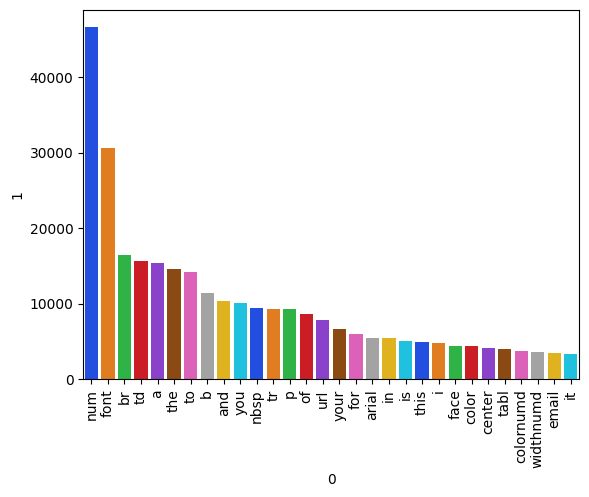

In [ ]:
spam_carpos = []
for sentence in X_transformed[(len(easy_ham) + len(hard_ham)):]:
    for word in sentence.split():
        spam_carpos.append(word)

from collections import Counter
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(30))

sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')
plt.xticks(rotation = 90)
plt.show()

<ipython-input-20-a08f93d4bef6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')


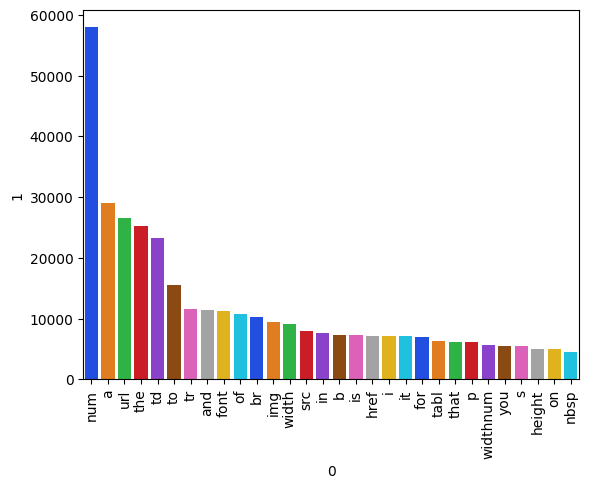

In [ ]:
spam_carpos = []
for sentence in X_transformed[:(len(easy_ham) + len(hard_ham))]:
    for word in sentence.split():
        spam_carpos.append(word)

from collections import Counter
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(30))

sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vectorize_messages(X),
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(vectorize_messages(X_transformed),
                                                                            y,
                                                                            test_size=0.2,
                                                                            random_state=42)

# Построение моделей машинного обучения

In [ ]:
svc = SVC()
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth = 5)
rfc = RandomForestClassifier(n_estimators = 50, random_state = 42)
gb = GradientBoostingClassifier(n_estimators = 50, random_state = 2)

In [ ]:
clfs = {
    'SVC': svc,
    'kNN': knc,
    'Naive Bayes': mnb,
    'Decision Tree': dtc,
    'Random Forest': rfc,
    'Gradient Boosting': gb,
}

In [ ]:
def train_classifier(clfs, X_train, y_train, X_test, y_test):
    clfs.fit(X_train,y_train)
    y_pred = clfs.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return accuracy, precision, recall

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []

for name, clfs in clfs.items():
    current_accuracy, current_precision, current_recall = train_classifier(clfs, X_train, y_train, X_test, y_test)
    print()
    print("For: ", name)
    print("Accuracy: ", current_accuracy)
    print("Precision: ", current_precision)
    print("Recall: ", current_recall)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)


For:  SVC
Accuracy:  0.940983606557377
Precision:  0.9418604651162791
Recall:  0.9204545454545454

For:  kNN
Accuracy:  0.9459016393442623
Precision:  0.9230769230769231
Recall:  0.9545454545454546

For:  Naive Bayes
Accuracy:  0.9688524590163935
Precision:  0.9919678714859438
Recall:  0.9356060606060606

For:  Decision Tree
Accuracy:  0.9377049180327869
Precision:  0.9346153846153846
Recall:  0.9204545454545454

For:  Random Forest
Accuracy:  0.9622950819672131
Precision:  0.9616858237547893
Recall:  0.9507575757575758

For:  Gradient Boosting
Accuracy:  0.9770491803278688
Precision:  0.9734848484848485
Recall:  0.9734848484848485


In [ ]:
feature_importances = rfc.feature_importances_
feature_importances_dictionary = {}
for feature, importance in enumerate(feature_importances):
    feature_importances_dictionary[X_train_transformed.columns[feature]] = importance
feature_importances_dataframe = pd.DataFrame(feature_importances_dictionary, index=['importance']).transpose()
feature_importances_dataframe.sort_values(by='importance', ascending=False).head(20)

IndexError: index 53230 is out of bounds for axis 0 with size 53230

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []

for name, clfs in clfs.items():
    current_accuracy, current_precision, current_recall = train_classifier(clfs, X_train_transformed, y_train, X_test_transformed, y_test)
    print()
    print("For: ", name)
    print("Accuracy: ", current_accuracy)
    print("Precision: ", current_precision)
    print("Recall: ", current_recall)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)


For:  SVC
Accuracy:  0.8081967213114755
Precision:  0.9349112426035503
Recall:  0.5984848484848485

For:  kNN
Accuracy:  0.9262295081967213
Precision:  0.9195402298850575
Recall:  0.9090909090909091

For:  Naive Bayes
Accuracy:  0.9655737704918033
Precision:  0.9840637450199203
Recall:  0.9356060606060606

For:  Decision Tree
Accuracy:  0.9098360655737705
Precision:  0.9003831417624522
Recall:  0.8901515151515151

For:  Random Forest
Accuracy:  0.9704918032786886
Precision:  0.9767441860465116
Recall:  0.9545454545454546

For:  Gradient Boosting
Accuracy:  0.9524590163934427
Precision:  0.9433962264150944
Recall:  0.946969696969697


Топ-3 лучших модели оказались:
- Random Forest
- Gradient Boosting
- Naive Bayes

In [ ]:
feature_importances = rfc.feature_importances_
feature_importances_dictionary = {}
for feature, importance in enumerate(feature_importances):
    feature_importances_dictionary[X_train_transformed.columns[feature]] = importance
feature_importances_dataframe = pd.DataFrame(feature_importances_dictionary, index=['importance']).transpose()
feature_importances_dataframe.sort_values(by='importance', ascending=False).head(20)

,importance
font,0.018809
our,0.017173
your,0.015219
wrote,0.014399
remov,0.012575
html,0.010930
but,0.008719
url,0.007830
group,0.007713
user,0.007423


In [ ]:
feature_importances = gb.feature_importances_
feature_importances_dictionary = {}
for feature, importance in enumerate(feature_importances):
    feature_importances_dictionary[X_train_transformed.columns[feature]] = importance
feature_importances_dataframe = pd.DataFrame(feature_importances_dictionary, index=['importance']).transpose()
feature_importances_dataframe.sort_values(by='importance', ascending=False).head(20)

,importance
our,0.121466
wrote,0.115420
url,0.107642
remov,0.103424
html,0.092095
subscript,0.072389
your,0.061348
spamassassinsight,0.034311
click,0.031973
user,0.031155


In [ ]:
best_clfs = {
    'Naive Bayes': mnb,
    'Random Forest': rfc,
    'Gradient Boosting': gb,
}

In [ ]:
from sklearn.model_selection import cross_val_predict

y_scores = {}

for name, clf in best_clfs.items():
    y_scores[name] = cross_val_predict(clf, X_train_transformed, y_train, cv=3,
                                           method='predict_proba')
    y_scores[name] = y_scores[name][:,1]

In [ ]:
from sklearn.metrics import roc_auc_score

print("ROC AUC scores:")
for clf_name, y_score in y_scores.items():
    roc_auc = roc_auc_score(y_train, y_score)
    print("- {}: {}".format(clf_name, roc_auc))

ROC AUC scores:
- Naive Bayes: 0.9734430212014135
- Random Forest: 0.9936045519087776
- Gradient Boosting: 0.988904078779076


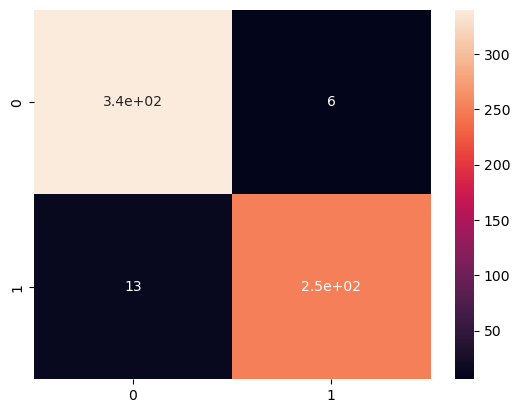

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
None

#